In [14]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import seaborn as sns
import pandas as pd

matplotlib.rcParams['text.usetex'] = True
%matplotlib inline

In [15]:
sns.set_theme()

In [16]:
base_path = Path('../experiments')
baseline_path = Path('../../bac-baselines/experiments')

In [54]:
env_name = 'Reacher (tight)'

In [55]:
pend_paths = {# 'BAC (seed 12)': 'random_init_12_2021-08-05/10-02-01/',
         #'BAC': 'pend_norm_tele_mg_3mc_2021-08-16/21-16-21',
         #'Rollout BAC': 'rollout_bac_telenorm_multi_2021-08-17/22-44-48/',
         'BARL': 'bac_pendulum_new_2021-09-20/21-43-49/',
         'RQMPC': 'random_pendulum_2021-09-20/14-14-23/',
         'MPC': 'mbrl_pendulum_new_2021-09-21/23-52-46/',
         'PETS': 'pets_pendulum_2021-09-06/15-03-19/',
         'SAC': 'sac_pendulum_2021-08-31/10-25-17/',
         'TD3': 'td3_pendulum_2021-08-31/16-43-52/',
         'PPO': 'ppo_pendulum_2021-08-31/12-20-16/',
        }

In [56]:
cartpole_paths = {
         # 'BAC': 'cartpole_multistart_2021-08-20/12-52-46/',
         'BARL': 'bac_cartpole_new_2021-09-20/21-43-53/',
         'RQMPC': 'random_cartpole_2021-09-20/14-43-50/',
         'MPC': 'mbrl_cartpole_new_2021-09-22/15-12-37/',
         # 'Rollout BAC': 'cartpole_multistart_rollout_bac_2021-08-19/17-59-03/',
         'PETS': 'pets_cartpole_2021-09-05/17-17-53/',
         'SAC': 'sac_cartpole_2021-09-23/23-41-37/',
         'TD3': 'td3_cartpole_2021-08-31/16-45-53/',
         'PPO': 'cartpole_ppo_fixed_2021-08-31/extra/',         
}

In [57]:
lava_paths = {
        # 'BAC': 'bac_lava_path_2021-09-09/10-57-31/',
        'BARL': 'bac_lava_path_ard_2021-09-21/22-02-46/',
        'RQMPC': 'random_lava_path_2021-09-23/00-00-49/',
        'MPC': 'mbrl_lava_path_ard_2021-09-22/19-46-54/',
        'PETS': 'pets_lava_path_2021-09-09/11-12-10/',
        'SAC': 'sac_lava_path_2021-09-09/09-59-07/',
        'TD3': 'td3_lava_path_2021-09-16/14-18-01/',
        'PPO': 'ppo_lava_path_2021-09-09/10-07-50/',
}

In [58]:
reacher_paths = {
        # 'BAC (uniform)': 'bac_reacher_2021-09-01/17-14-04/',
        # 'BAC (path sampling)': 'bac_reacher_rand_2021-09-01/17-14-02/',
        #'SAC': 'sac_reacher_2021-09-02/22-41-22/',
        'BAC (ARD)': 'ard_reacher_bac_2021-09-18/14-59-33/',
        'BAC (periodic ARD)':'reacher_periodic_bac_2021-09-18/15-26-28/',
        # 'Random (ARD)': 'random_reacher_2021-09-20/13-28-12/',
}

In [59]:
beta_tracking_paths = {
        'BARL': 'bac_beta_tracking_2021-09-22/19-02-05/',
        'RQMPC': 'random_beta_tracking_2021-09-23/18-36-44/',
        'MPC': 'mbrl_beta_tracking_2021-09-23/18-37-08/',
        'PETS': 'pets_beta_tracking_2021-09-22/18-51-05/',
        'SAC': 'sac_beta_tracking_2021-09-23/09-27-24/',
        'TD3': 'td3_beta_tracking_2021-09-22/18-30-55/',
        'PPO': 'ppo_beta_tracking_2021-09-22/18-32-20/',
}

In [69]:
reacher_tight_paths = {
        'BAC (ARD)': 'bac_reacher_tight_ard_2021-09-21/10-06-46/',
        'Random (ARD)': 'random_reacher_tight_ard_2021-09-21/23-56-00/',
        'PETS': 'pets_reacher_tight_2021-09-22/18-59-17/',
        # 'SAC': 'sac_reacher_tight_2021-09-22/18-34-13/',
        # 'TD3': 'td3_reacher_tight_2021-09-22/15-24-00/',
        # 'PPO': 'ppo_reacher_tight_2021-09-22/15-25-08/',
}

In [70]:
swimmer_paths = {
        'BAC (ARD)': 'bac_swimmer_ard_2021-09-17/15-13-29/'
}

In [71]:
all_paths = {"Cartpole": cartpole_paths,
             "Pendulum": pend_paths,
             "Reacher": reacher_paths, 
             'Lava Path': lava_paths, 
             "Reacher (tight)": reacher_tight_paths,
             "Beta Tracking": beta_tracking_paths,
             'Swimmer': swimmer_paths,
            }
paths = all_paths[env_name]
gt = {"Pendulum": -250,
      "Cartpole": -13,
      "Reacher": -5,
      'Lava Path': -25,
      'Reacher (tight)': -8.78,
      'Swimmer': 30,
      'Beta Tracking': -3}
gt_val = gt[env_name]

In [72]:
def process_bac(data):
    returns = np.vstack(data['Eval Returns'])

    data['Eval Mean Returns'] = returns.mean(axis=1)
    data['Eval Std Returns'] = returns.std(axis=1)#  / np.sqrt(returns.shape[1])
    return data

def process_baseline(data):
    out = {}
    out['Eval Mean Returns'] = data["evaluation/Returns Mean"]
    out['Eval ndata'] = data['exploration/num steps total']
    out['Eval Std Returns'] = data['evaluation/Returns Std']
    return out

In [73]:
data = {}
for key, path in paths.items():
    print(key)
    info_path = base_path / path / 'info.pkl'
    if info_path.exists():
        with info_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    baseline_exp_path = baseline_path / path / 'progress.csv'
    if baseline_exp_path.exists():
        data_res = pd.read_csv(baseline_exp_path)
        reformatted_data = process_baseline(data_res)
        data[key] = reformatted_data
        continue
    baseline_pkl_path = baseline_path / path / 'info.pkl'
    if baseline_pkl_path.exists():
        with baseline_pkl_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    print(f"Data for {key} not found!")

BAC (ARD)
Random (ARD)
PETS


Text(0.5, 0.98, 'Control Performance on Reacher (tight)')

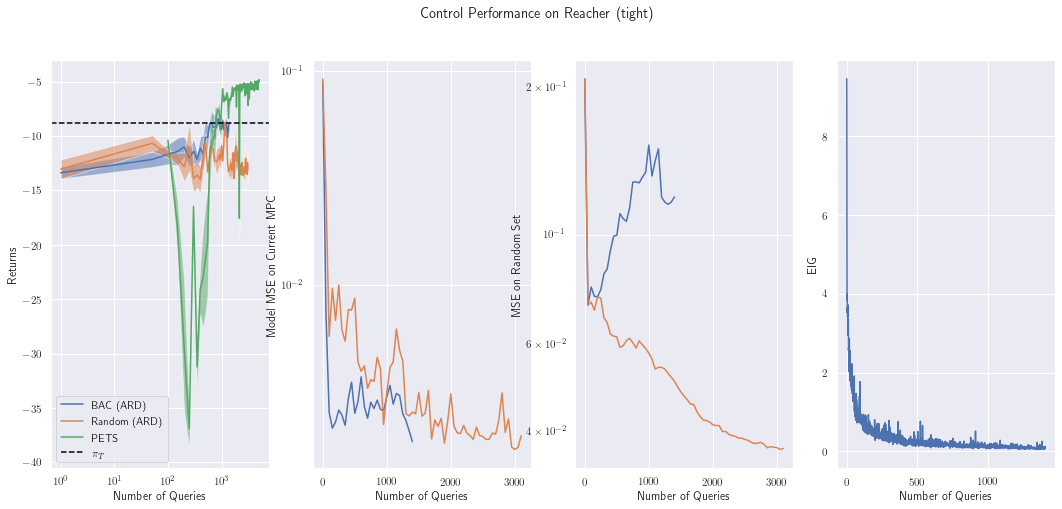

In [74]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(18, 7.5))
for key, vals in data.items():
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax1.plot(ndata, rmean, label=key)
    ax1.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
    if 'Model MSE' in vals:
        mses = vals['Model MSE']
        ax2.plot(ndata, mses, label=key)
    elif 'Model MSE (current MPC)' in vals:
        mses = vals['Model MSE (current MPC)']
        ax2.plot(ndata, mses, label=key)
    if 'Model MSE (random test set)' in vals:
        mses = vals['Model MSE (random test set)']
        ax3.plot(ndata, mses, label=key)
    if 'Acquisition Function Value' in vals:
        acqs = vals['Acquisition Function Value']
        ax4.plot(acqs, label=key)
    else:
        ax4.plot([], label=key)

        
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Returns')
ax1.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax1.legend()
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Model MSE on Current MPC')
ax3.set_ylabel("MSE on Random Set")
ax3.set_xlabel('Number of Queries')
ax4.set_xlabel('Number of Queries')
ax4.set_ylabel('EIG')
if env_name == 'Lava Path':
    ax1.set_ylim(-1000, 0)
ax2.set_yscale('log')
ax3.set_yscale('log')
ax1.set_xscale('log')

fig.suptitle(f"Control Performance on {env_name}")


Text(0.5, 0.98, 'Control Performance on Reacher (tight)')

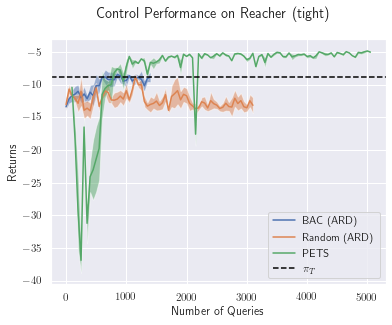

In [78]:
fig, ax = plt.subplots(figsize=(6, 4.5))
for key, vals in data.items():
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
ax.set_xlabel('Number of Queries')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax.legend()
if env_name == 'Lava Path':
    ax.set_ylim(-500, 0)
if env_name == 'Beta Tracking':
    ax.set_ylim(-15, 0)
# ax.set_xscale('log')

fig.suptitle(f"Control Performance on {env_name}")

In [76]:
print(f"Sample complexity of algorithms on {env_name}")
for key, vals in data.items():
    rmean = vals["Eval Mean Returns"]
    try:
        sample_idx = np.where(rmean > gt_val)[0].min()
        sample_complexity = vals['Eval ndata'][sample_idx]
    except ValueError:
        sample_complexity = None
    
    print(f"{key}: {sample_complexity}")

Sample complexity of algorithms on Reacher (tight)
BAC (ARD): 851
Random (ARD): 1151
PETS: 800


In [77]:
data['PETS']['Eval Mean Returns']

array([-10.38542941, -18.26320851, -29.28655622, -36.88943797,
       -16.47995598, -31.22414376, -24.09583021, -23.03842367,
       -21.39477094, -19.75617436, -11.48684082, -10.54584879,
       -10.11880807,  -9.9883833 ,  -8.16010439,  -7.57517107,
        -7.73197352,  -9.43151143,  -7.25710194,  -5.65125618,
        -6.84071858,  -6.42876521,  -6.71227627,  -6.0304843 ,
        -6.34758637,  -8.38812354,  -6.56307198,  -6.70764225,
        -6.50980495,  -6.19519196,  -5.5020905 ,  -6.36815451,
        -5.7499932 ,  -5.60568241,  -5.80571074,  -5.48351367,
        -7.34361349,  -5.31244454,  -5.65046178,  -5.33720129,
        -5.87879361, -17.5690609 ,  -5.24690725,  -5.9263689 ,
        -5.24464653,  -5.42828087,  -5.85291406,  -5.61876248,
        -5.24072186,  -5.58036544,  -5.11484725,  -5.44225706,
        -5.58221048,  -6.31783607,  -5.27710392,  -5.20233673,
        -5.27783776,  -5.60548557,  -6.16008481,  -5.93678235,
        -5.18196397,  -7.21454605,  -5.65950702,  -5.38